## Quadratic programming method for vehicle trajectory correcting and smoothing from noisy data

## Application to the highD dataset (section 5.3)

In [30]:
def differentiation(lower_order, higher_order, delta_t,  order_ind):
    import copy
    new_array = copy.deepcopy(lower_order);
    update_higher = copy.deepcopy(higher_order);
    if order_ind == 1 or order_ind == 3 or order_ind == 5: #differentiate implicit (for speeds and jerks) 
        update_higher[ 1 : ] = (new_array[ 1 : ]-new_array[ : len(new_array)-1]) / delta_t #(eq 2a)
    elif order_ind == 2 or order_ind == 4 or order_ind == 6: #differentiate explicit (for accelerations and snaps)
        update_higher[ : len(new_array)-1] = (new_array[1 : ]-new_array[ : len(new_array)-1]) / delta_t #(eq 2b)
        
    return update_higher

In [31]:
def difference_matrix(v_num): # the input is the number of speeds of one vehicle, the outputs are difference matrices
    diff0_0 = -np.identity(v_num+1); diff0_1 = np.identity(v_num+1); # for positions
    diff1 = np.zeros((2*v_num,v_num+1)); # for speeds
    diff2 = np.zeros((2*v_num-2,v_num+1)); # for accelerations
    diff3 = np.zeros((2*v_num-4,v_num+1)); # for jerks
    diff4 = np.zeros((2*v_num-6,v_num+1)); # for snaps
    '''The following calculations correspond to (eq 5) regarding different k'''
    for i in range(v_num): #coefficient matrix for speeds
        diff1[i,i:i+2] = [1,-1] 
        diff1[i+v_num,i:i+2] = [-1,1]
    for i in range(v_num-1): #coefficient matrix for accelerations
        diff2[i,i:i+3] = [-1,2,-1] 
        diff2[i+(v_num-1),i:i+3] = [1,-2,1] 
    for i in range(v_num-2): #coefficient matrix for jerks
        diff3[i,i:i+4] = [1,-3,3,-1] 
        diff3[i+(v_num-2),i:i+4] = [-1,3,-3,1] 
    for i in range(v_num-3): #coefficient matrix for snaps
        diff4[i,i:i+5] = [-1,4,-6,4,-1] 
        diff4[i+(v_num-3),i:i+5] = [1,-4,6,-4,1] 
    return diff0_0, diff0_1, diff1, diff2, diff3, diff4

In [32]:
#The code for calculate half-smoothed positions (step 1)
def reconstruct_traj_l2(raw_x, id, down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, cons_id): # the input is the raw position, speed bounds, acceleration bounds, jerk bounds, snap bounds
    M = len(raw_x) - 1
    x = cp.Variable(M+1) #Define variables
    # coefficient matrix
    W0_0, W0_1, W1, W2, W3, W4 = difference_matrix(M)
    '''the coefficient matrix and the right side of the constraints, (eq 9a)-(eq 9e)'''
    f = int(round(1/delta_t,0)); 
    
    coe_l = np.vstack( (W0_0,W0_1,W1*f,W2*(f**2),W3*(f**3)) );  #coefficient matrix of constraints
    coe_r = np.vstack( ( np.array([0]*(M+1)).reshape(M+1,1), np.array([550]*(M+1)).reshape(M+1,1), -np.array([down_v]*M).reshape(M,1), np.array([up_v]*M).reshape(M,1),
                        np.array([-down_a]*(M-1)).reshape(M-1,1), np.array([up_a]*(M-1)).reshape(M-1,1), np.array([-down_j]*(M-2)).reshape(M-2,1), np.array([up_j]*(M-2)).reshape(M-2,1)) ).reshape(8*M-4,) #right side of constraints
    cons = [coe_l @ x <= coe_r] #constraints, AX <= b

    obj = cp.sum_squares(x - raw_x) #objective function
    model = cp.Problem(cp.Minimize(obj), cons)
    #solve the model
    model.solve(solver=cp.GUROBI, verbose = False, BarHomogeneous = 1, NumericFocus = 3, Aggregate = 0, ScaleFlag=2)
    new_x = x.value; pos_array = np.array(raw_x).reshape(len(raw_x),1) #reconstructed positions and raw_positions
    
    return new_x, pos_array, model 

In [33]:
def position_limit(raw_x, id, down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, est_acc, cons_id): 
    #the input are the raw positions, and the outputs are lower bound and the upper bound of the position
    import copy
    new_x, raw_pos, pos_model = reconstruct_traj_l2(raw_x, id, down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, cons_id); #calculate the reconstructed positions based on l_2 norm minimization
    raw_up = raw_x + est_acc; raw_down = raw_x - est_acc #upper and lower limit of the raw position, if it is a feasible region, then this is the position constraint
    upper_x = np.maximum(raw_x + est_acc, new_x); lower_x = np.minimum(raw_x - est_acc, new_x) #(eq 10) 
    return upper_x, lower_x, new_x

In [34]:
# The code for minimizing the highest-order derivatives (step 2)
def reconstruct_traj_minhighest(raw_x, id, down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, est_acc, uniqueness, cons_id): # the input is the raw position, speed bounds, acceleration bounds, jerk bounds, snap bounds
    M = len(raw_x) - 1
    x = cp.Variable(M+1, pos = True) #Define variables
    pos_up, pos_down, l2_pos = position_limit(raw_x, id, down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, est_acc, cons_id) #lower bound and upper bound of positions
    '''the coefficient matrix and the right side of the constraints, (eq 13a)-(eq 13f)'''
    W0_0, W0_1, W1, W2, W3, W4 = difference_matrix(M)
    f = int(round(1/delta_t,0)); 
    
    coe_l = np.vstack( (W0_0,W0_1,W1*f,W2*(f**2),W3*(f**3)) ); #coefficient matrix of constraints
    coe_r = np.vstack( ( -pos_down.reshape(M+1,1), pos_up.reshape(M+1,1), np.array([down_v]*M).reshape(M,1), np.array([up_v]*M).reshape(M,1), 
                        np.array([-down_a]*(M-1)).reshape((M-1),1), np.array([up_a]*(M-1)).reshape((M-1),1), np.array([-down_j]*(M-2)).reshape((M-2),1), np.array([up_j]*(M-2)).reshape((M-2),1) ) ).reshape(8*M-4,) #right side of constraints
    obj = cp.sum_squares(((W3[M-2:]*(f**3)) @ x)[:]) #objective function
    cons = [coe_l @ x <= coe_r, x[0] == l2_pos[0], x[1] == l2_pos[1], x[2] == l2_pos[2]] #constraints, AX <= b, make the initial three values known
    model = cp.Problem(cp.Minimize(obj), cons)
    model.solve(solver=cp.GUROBI, verbose = False, BarHomogeneous = 1, NumericFocus = 3, Aggregate = 0, ScaleFlag=2) 
    
    #print("status",model.status,"The optimal value is", round(model.value,5))
    new_x = x.value; pos_array = np.array(raw_x).reshape(len(raw_x),1); l2_pos = l2_pos.reshape(len(l2_pos),1) #reconstructed positions and raw_positions
        
    return new_x, l2_pos, pos_array, model 

In [35]:
# Code for calculating the higher-order derivatives of smoothed positions
def higher_order_calc_pos(old_matrix, down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, est_acc, uniqueness, cons_id):
    new_array_np = old_matrix.values
    id_set = sorted(set(new_array_np[:,0].tolist()),key = new_array_np[:,0].tolist().index)#pick out all the ids, and create a list to store them
    cal_array = np.zeros((1,21)); cal_array_l2 = np.zeros((1,21))
    for n_id in range(len(id_set)):
        new_matrix = new_array_np[np.where(new_array_np[:,0] == id_set[n_id] )]; new_matrix_l2 = new_array_np[np.where(new_array_np[:,0] == id_set[n_id] )]
        raw_pos = new_matrix[:,-14] 
        l2_x, l2_pos_array, l2_model = reconstruct_traj_l2(raw_pos, id_set[n_id], down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, cons_id) 
        new_pos, l2_position, original_pos, model_pos = reconstruct_traj_minhighest(raw_pos, id_set[n_id], down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, est_acc, uniqueness, cons_id)
        l2_x = l2_x.reshape(len(raw_pos),1); new_pos = new_pos.reshape(len(raw_pos),1)
        #half-smoothed positions and higher order derivatives
        new_matrix_l2[:,-7] = l2_x[:,0];
        new_matrix_l2[1:,-6] =   differentiation(new_matrix_l2[:,-7], new_matrix_l2[:,-13], delta_t,  order_ind = 1)[1:] #speed implicit
        new_matrix_l2[1:-1,-5] = differentiation(new_matrix_l2[:,-6], new_matrix_l2[:,-12], delta_t,  order_ind = 2)[1:-1]  #acceleration explicit
        new_matrix_l2[2:-1,-4] = differentiation(new_matrix_l2[:,-5], new_matrix_l2[:,-11], delta_t,  order_ind = 3)[2:-1]  #jerk implicit
        new_matrix_l2[2:-2,-3] = differentiation(new_matrix_l2[:,-4], new_matrix_l2[:,-10], delta_t,  order_ind = 4)[2:-2]  #snap explicit
        new_matrix_l2 = new_matrix_l2[:]
        cal_array_l2 = np.vstack((cal_array_l2, new_matrix_l2))
        #smoothed positions and higher order derivatives
        new_matrix[:,-7] = new_pos[:,0]; 
        new_matrix[1:,-6] =  differentiation(new_matrix[:,-7], new_matrix[:,-13], delta_t,  order_ind = 1)[1:]   #speed implicit
        new_matrix[1:-1,-5] = differentiation(new_matrix[:,-6], new_matrix[:,-12], delta_t,  order_ind = 2)[1:-1]  #acceleration explicit
        new_matrix[2:-1,-4] = differentiation(new_matrix[:,-5], new_matrix[:,-11], delta_t,  order_ind = 3)[2:-1]  #jerk implicit
        new_matrix[2:-2,-3] = differentiation(new_matrix[:,-4], new_matrix[:,-10], delta_t,  order_ind = 4)[2:-2]  #snap explicit
        new_matrix = new_matrix[:]
        cal_array = np.vstack((cal_array, new_matrix)) #[2:-2]
        pos_error = np.mean(np.abs(new_matrix[:, -14] - new_matrix[:, -7])); #calculate the MAE between raw and reconstructed trajectory of one vehicle 
        obj_v = round(np.sum(new_matrix[:, -6]**2),3); obj_a = round(np.sum(new_matrix[:, -5]**2),3); obj_j = round(np.sum(new_matrix[:, -4]**2),3); obj_s = round(np.sum(new_matrix[:, -3]**2),3); 
        #print("id", id_set[n_id] ,"pos_error", pos_error, "obj_v", obj_v, "obj_a", obj_a, "obj_j", obj_j, "obj_s", obj_s) 
    cal_array = cal_array[1: ]; cal_array_l2 = cal_array_l2[1: ]
    pos_error = np.mean(np.abs(cal_array[:,-14]-cal_array[:,-7])); print("pos_error", pos_error, "$m$") #calculate the MAE between raw and reconstructed trajectory of the dataset
    return cal_array, cal_array_l2

In [36]:
#Load the data
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cvxpy as cp
from cvxpy import *
import gurobipy as gp
 
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)
pd.set_option('display.float_format',lambda x : '%.3f' % x)
np.set_printoptions(precision=3, suppress=True)#3 digit, no scientific notation
np.set_printoptions(threshold=np.inf) #no ellipses

veh_traj = pd.read_csv('25_tracks.csv', usecols = ['id','frame','y','x','width', 'precedingId','followingId'])
order = ['id','frame','y','x','width', 'precedingId','followingId']
veh_traj = veh_traj[order]

#add 14 columns at the end, called "distance", "velocity", "acceleration", "jerk", "snap", "spacing", and "relative speed"
veh_traj['distance'] = 0
veh_traj['velocity'] = 0
veh_traj['acceleration'] = 0 
veh_traj['jerk'] = 0 
veh_traj['snap'] = 0
veh_traj['delta_x'] = 0
veh_traj['delta_v'] = 0
veh_traj['smooth_x'] = 0
veh_traj['smooth_v'] = 0
veh_traj['smooth_a'] = 0
veh_traj['smooth_j'] = 0
veh_traj['smooth_s'] = 0
veh_traj['smooth_delta_x'] = 0
veh_traj['smooth_delta_v'] = 0

veh_traj

,id,frame,y,x,width,precedingId,followingId,distance,velocity,acceleration,...,snap,delta_x,delta_v,smooth_x,smooth_v,smooth_a,smooth_j,smooth_s,smooth_delta_x,smooth_delta_v
0,1,1,32.170,366.390,5.150,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,32.170,366.980,5.150,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,32.180,367.610,5.150,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,4,32.190,368.250,5.150,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,5,32.200,368.900,5.150,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019747,2850,29456,39.150,21.750,5.860,2845,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019748,2850,29457,39.150,22.220,5.860,2845,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019749,2850,29458,39.140,22.700,5.860,2845,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019750,2850,29459,39.140,23.190,5.860,2845,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# This module is used as an application function of our method
def method_application(raw_traj, down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, est_acc, uniqueness, cons_id):
    original_array = raw_traj.values
    import copy
    new_array_np = copy.deepcopy(original_array); cal_array = np.zeros((1,21));
    id_set = sorted(set(new_array_np[:,0].tolist()),key = new_array_np[:,0].tolist().index)#pick out all the ids, and create a list to store them [new_array_np[410000,0]] #
    for n_id in range(len(id_set)): #go over each vehicle
        new_array = new_array_np[np.where(new_array_np[:,0] == id_set[n_id] )] 
        new_array[:,-14] = np.absolute(new_array[:,3] - new_array[0,3]) + 4 #moving distance 
        new_array[:,2] = (new_array[:,1] - new_array[0,1]) * delta_t #time 
        new_array[1:,-13] = differentiation(new_array[:,-14], new_array[:,-13], delta_t,  order_ind = 1)[1:] #speed implicit, Eq 1a
        new_array[1:-1,-12] = differentiation(new_array[:,-13], new_array[:,-12], delta_t,  order_ind = 2)[1:-1] #acceleration explicit, Eq 1b
        new_array[2:-1,-11] = differentiation(new_array[:,-12], new_array[:,-11], delta_t,  order_ind = 3)[2:-1] #jerk implicit, Eq 1c
        new_array[2:-2,-10] = differentiation(new_array[:,-11], new_array[:,-10], delta_t,  order_ind = 4)[2:-2] #snap explicit, Eq 1d

        cal_array = np.vstack((cal_array, new_array));
    veh_update = pd.DataFrame(copy.deepcopy(cal_array[1:]));
    smooth_veh2, smooth_veh1 = higher_order_calc_pos(veh_update[:], down_v, up_v, down_a, up_a, down_j, up_j, down_s, up_s, delta_t, est_acc, uniqueness, cons_id)

    return smooth_veh2, smooth_veh1

In [38]:
def calc_time(veh_traj, down_vel, up_vel, down_acc, up_acc, down_jerk, up_jerk, down_snap, up_snap, delta_t, est_acc, unique, highest_order):
    import time; time_list = []
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++min jerk+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    T1_j = time.time()
    smooth_veh_jerk, smooth_veh_l2j = method_application(veh_traj, down_vel, up_vel, down_acc, up_acc, down_jerk, up_jerk, down_snap, up_snap, delta_t, est_acc, unique, highest_order)
    T2_j = time.time(); 
    
    time_list.append(round((T2_j - T1_j),3))
    print("time_list", time_list)
    

    return smooth_veh_jerk, time_list, smooth_veh_l2j
down_vel = 0; up_vel = 50; down_acc = -5; up_acc = 4; down_jerk = -8; up_jerk = 8; down_snap = -12; up_snap = 12; 
delta_t = 0.04; est_acc = 0.1; unique = 1; non_unique = 0; highest_order = 3
 
id_car = 1011
id_num = [id_car, 1005] # sample vehicle and its front vehicle
smooth_veh_j, run_time, smooth_l2j = calc_time(veh_traj, down_vel, 
up_vel, down_acc, up_acc, down_jerk, up_jerk, down_snap, up_snap, delta_t, est_acc, unique, highest_order) #[veh_traj['id'].isin(id_num)]
pd.DataFrame(smooth_veh_j, columns = ['Vehicle_ID','Frame_ID','Global_Time','Local_Y','v_Length', 'Preceding','Following', 'x', 'v', 'a', 'j', 's', 'delta_x', 'delta_v', 'smooth_x', 'smooth_v', 'smooth_a', 'smooth_j', 'smooth_s', 'smooth_deltax', 'smooth_deltav'])

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++min jerk+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-02
pos_error 0.05234977394201237 $m$
time_list [3623.503]


,Vehicle_ID,Frame_ID,Global_Time,Local_Y,v_Length,Preceding,Following,x,v,a,...,s,delta_x,delta_v,smooth_x,smooth_v,smooth_a,smooth_j,smooth_s,smooth_deltax,smooth_deltav
0,1.000,1.000,0.000,366.390,5.150,0.000,5.000,4.000,0.000,0.000,...,0.000,0.000,0.000,3.979,0.000,0.000,0.000,0.000,0.000,0.000
1,1.000,2.000,0.040,366.980,5.150,0.000,5.000,4.590,14.750,25.000,...,0.000,0.000,0.000,4.602,15.590,4.000,0.000,0.000,0.000,0.000
2,1.000,3.000,0.080,367.610,5.150,0.000,5.000,5.220,15.750,6.250,...,11718.750,0.000,0.000,5.232,15.750,3.680,-8.000,0.000,0.000,0.000
3,1.000,4.000,0.120,368.250,5.150,0.000,5.000,5.860,16.000,6.250,...,-3906.250,0.000,0.000,5.868,15.897,3.360,-8.000,0.000,0.000,0.000
4,1.000,5.000,0.160,368.900,5.150,0.000,5.000,6.510,16.250,0.000,...,7812.500,0.000,0.000,6.510,16.032,3.040,-8.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019747,2850.000,29456.000,1.120,21.750,5.860,2845.000,0.000,17.800,12.000,-6.250,...,0.000,0.000,0.000,17.882,12.150,-0.911,-0.052,0.862,0.000,0.000
2019748,2850.000,29457.000,1.160,22.220,5.860,2845.000,0.000,18.270,11.750,6.250,...,-7812.500,0.000,0.000,18.367,12.114,-0.911,-0.017,0.431,0.000,0.000
2019749,2850.000,29458.000,1.200,22.700,5.860,2845.000,0.000,18.750,12.000,6.250,...,-7812.500,0.000,0.000,18.850,12.077,-0.911,-0.000,0.000,0.000,0.000
2019750,2850.000,29459.000,1.240,23.190,5.860,2845.000,0.000,19.240,12.250,-6.250,...,0.000,0.000,0.000,19.332,12.041,-0.911,0.000,0.000,0.000,0.000


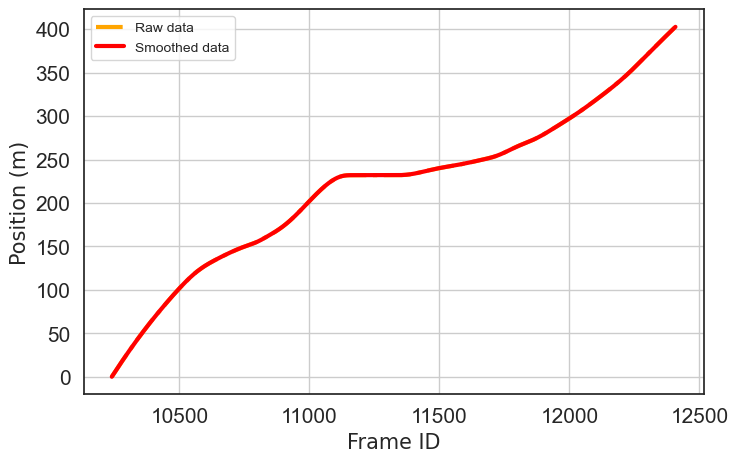

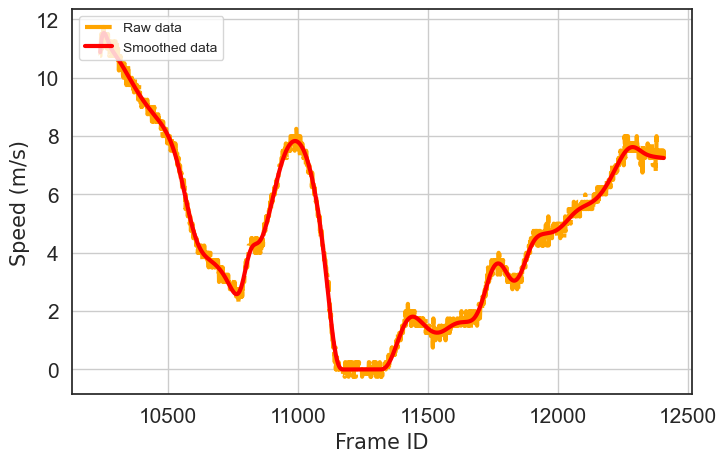

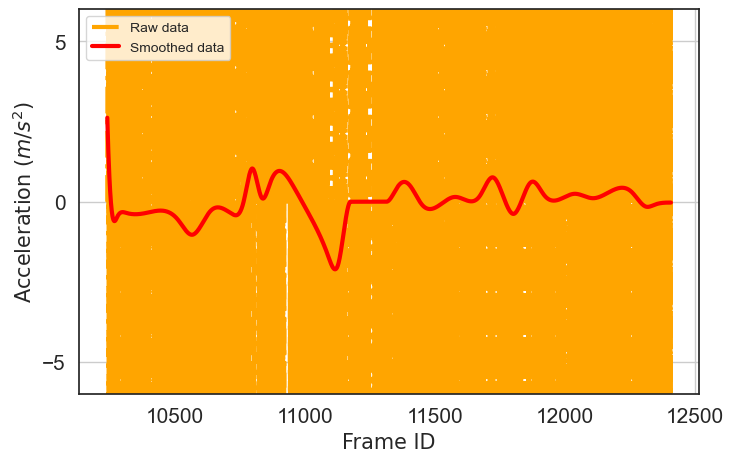

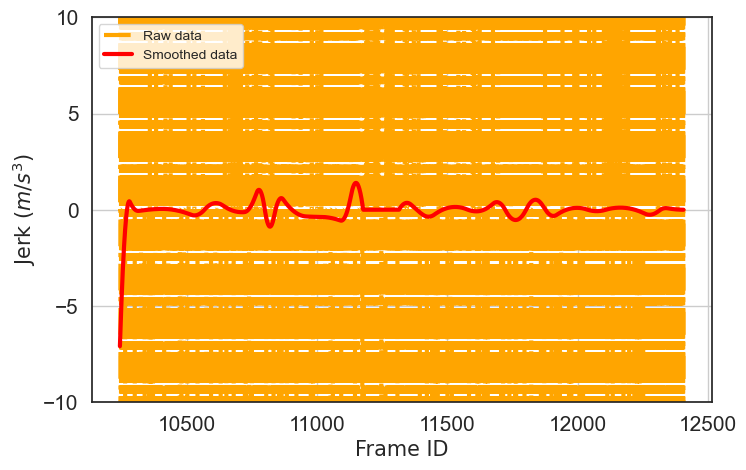

In [37]:
font1 = 10; lo = 2; line = 3; line2 = 3; line3 = 3; s1 = 15
font2 = {'family' : 'DejaVu Sans', 'weight' : 'normal', 'size' : 15,}
plt.figure(figsize=(8,5));
plt.figure(1)
plt.ylabel("Position (m)",font2); plt.xlabel("Frame ID",font2)
plt.xticks(fontsize= s1); plt.yticks(fontsize= s1)
plt.plot(smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][:,1],np.abs(smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][:,3]-smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][0,3]), color = "orange", linewidth=line, linestyle='-.', label = "Raw data"); 
plt.plot(smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][:,1],np.abs(smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][:,3]-smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][0,3])+smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][:,-7]-smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][:,-14], color = "r", linewidth= line2, label = "Smoothed data"),
plt.grid(); plt.legend(fontsize=font1 , loc = lo); #plt.show() , loc = lo

plt.figure(figsize=(8,5)); 
plt.figure(2); #plt.ylim(13.5,17.5)
plt.ylabel("Speed (m/s)",font2); plt.xlabel("Frame ID",font2)
plt.xticks(fontsize= s1); plt.yticks(fontsize= s1) 
plt.plot(smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][1:,1],smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][1:,-13], color = "orange", linewidth=line, linestyle='-.', label = "Raw data"); 
plt.plot(smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][1:,1],smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][1:,-6], color = "r", linewidth= line2, label = "Smoothed data");
plt.grid(); plt.legend(fontsize=font1 , loc = lo); #plt.show()


plt.figure(figsize=(8,5)); plt.ylim(-6,6)
plt.figure(3); 
plt.ylabel("Acceleration ($m/s^2$)",font2); plt.xlabel("Frame ID",font2) 
plt.xticks(fontsize= s1); plt.yticks(np.arange(-5,5.5,5),fontsize= s1)
plt.plot(smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][1:-1,1],smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][1:-1,-12], color = "orange", linewidth=line, linestyle='-.', label = "Raw data"); 
plt.plot(smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][1:-1,1],smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][1:-1,-5], color = "r", linewidth= line2, label = "Smoothed data");
plt.grid(); plt.legend(fontsize=font1, loc = lo); #plt.show()

plt.figure(figsize=(8,5)); plt.ylim(-10,10)
plt.figure(4)
plt.ylabel("Jerk ($m/s^3$)",font2); plt.xlabel("Frame ID",font2)
plt.xticks(fontsize= s1); plt.yticks(np.arange(-10,10.5,5),fontsize= s1)
plt.plot(smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][2:-1,1],smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][2:-1,-11], color = "orange", linewidth=line, linestyle='-.', label = "Raw data"); 
plt.plot(smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][2:-1,1],smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])][2:-1,-4], color = "r", linewidth= line2, label = "Smoothed data");
plt.grid(); plt.legend(fontsize=font1, loc = lo); #plt.show()

[1011.0]


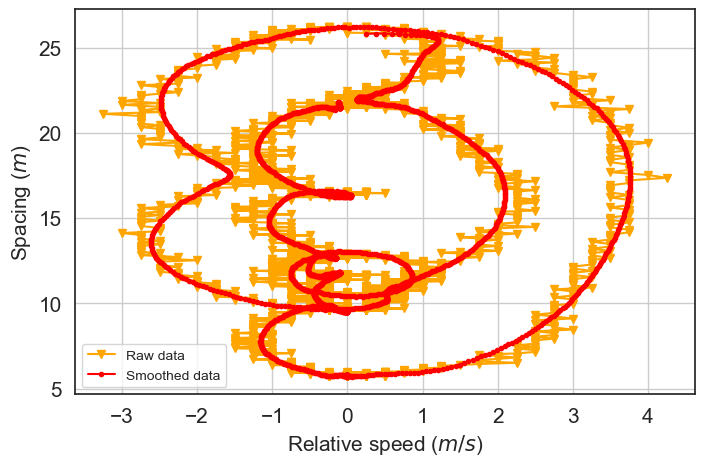

In [38]:
#Wiedemann plot
id_car = 1011
id_num = [id_car, 994] 
def relative(data, full_data):
    import copy
    new_array_np = copy.deepcopy(data); update_rho = np.zeros((1,21)) #used to store the updated data
    id_set = sorted(set(new_array_np[:,0].tolist()),key = new_array_np[:,0].tolist().index)#pick out all the ids, and create a list to store them
    travel_dis = np.zeros((len(id_set), 2))
    travel_dis[:,0] = id_set; print(id_set)
    #id_set = [id_num]
    for n_id in range(len(id_set)): #go over each vehicle
        sub_veh = new_array_np[np.where(new_array_np[:,0] == id_set[n_id] )][1:]
        travel_dis[n_id, 1] = (sub_veh[-7,-1] - sub_veh[-7, 0]) - (sub_veh[14,-1] - sub_veh[14, 0])
        for i in range(len(sub_veh)):
            if sub_veh[i,5] == 0: # no leadning vehicle
                sub_veh[i,-9] = 500; sub_veh[i,-8] = 500
                sub_veh[i,-2] = 500; sub_veh[i,-1] = 500
            else:
                leading = full_data[np.where( (full_data[:,0] == sub_veh[i,5]) & (full_data[:,1] == sub_veh[i,1]) )] #leading vehicle at this time step
                if len(leading) > 0:
                    sub_veh[i,-9] = leading[0,3] - sub_veh[i,3] if sub_veh[0,3] < sub_veh[-1,3] else -leading[0,3] + sub_veh[i,3] # raw spacing
                    sub_veh[i,-2] = (leading[0,3] + leading[0,-7] - leading[0,-14]) - (sub_veh[i,3] + sub_veh[i,-7]-sub_veh[i,-14]) if sub_veh[0,3] < sub_veh[-1,3] else -(leading[0,3] + leading[0,-7] - leading[0,-14]) + (sub_veh[i,3] + sub_veh[i,-7]-sub_veh[i,-14]) #spacing after smoothing
                    sub_veh[i,-8] = - leading[0,-13] + sub_veh[i,-13] #raw relative speed
                    sub_veh[i,-1] = - leading[0,-6] + sub_veh[i,-6] #smoothed relative speed
                elif len(leading) == 0:
                    sub_veh[i,-9] = 500; sub_veh[i,-8] = 500
                    sub_veh[i,-2] = 500; sub_veh[i,-1] = 500
        sub_veh = sub_veh[np.where(sub_veh[:,-1] != 500)]
        update_rho = np.vstack((update_rho, sub_veh)) #combine the individual data
        update_rho = update_rho[1:]
    return pd.DataFrame(update_rho), travel_dis

full_smooth, travel_len = relative(smooth_veh_j[np.where(smooth_veh_j[:,0]==id_num[0])], smooth_veh_j)
for n_id in range(len([id_num[0]])):
    plt.figure(figsize=(8,5)); #plt.ylim(0,40)
    plt.tick_params(labelsize=s1)
    plt.figure(n_id+1)
    plt.ylabel("Spacing ($m$)", fontsize=s1); plt.xlabel("Relative speed ($m/s$)", fontsize=s1)
    plt.plot(full_smooth.values[:,-8], full_smooth.values[:,-9], color = "orange", marker = 'v', markersize = 6, label = "Raw data"); #linewidth=1, linestyle='-',
    plt.plot(full_smooth.values[:,-1], full_smooth.values[:,-2], color = "r", marker = 'o', markersize = 3, label = "Smoothed data");
    plt.grid(); plt.legend(fontsize=font1)

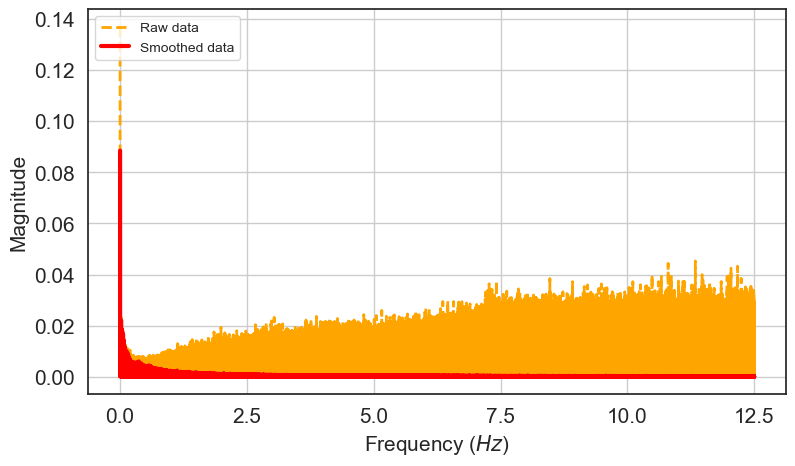

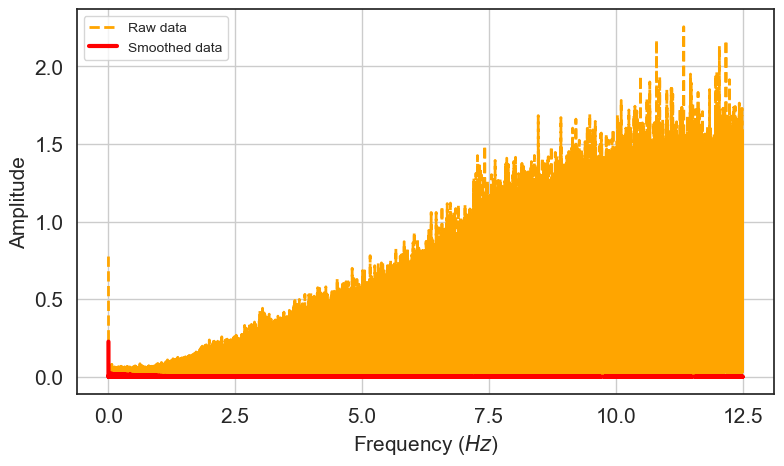

In [47]:
def displaySpectrum_smooth(data_a):
    import copy; from scipy.fftpack import fft
    import seaborn as sns
    from scipy import fftpack, arange; import matplotlib.pyplot as plt
    from pylab import plot, show, title, xlabel, ylabel, subplot
    
    N = len(data_a); duration = N*0.04; dt = 0.04 #duration and sampling step(s)
    fs = int(round(1/dt,0)); #sampling frequency
    series_raw = copy.deepcopy(data_a); #series_smooth = copy.deepcopy(data_smooth); 
    hat_a_hz = fft(series_raw[:,9],N); hat_j_hz = fft(series_raw[:,10],N); #raw data
    aa_hz = fft(data_a[:,-5],N); aj_hz = fft(data_a[:,-4],N); #Our method
    
    frq = np.linspace(0, fs, N)
    raw_a = 2*(np.absolute(hat_a_hz))/N; raw_j = 2*(np.absolute(hat_j_hz))/N;  
    mag_aa = 2*(np.absolute(aa_hz))/N; mag_aj = 2*(np.absolute(aj_hz))/N; #Our method
    
    s1 = 15; font2 = {'weight' : 'normal', 'size' : s1,}; 
    sns.set(rc={"figure.figsize": (9,5)}, style="white", palette=None)
    plt.figure(figsize=(9,5)); plt.xticks(np.arange(0, 25.5, 2.5)) #plt.xlim(0,100)
    plt.figure(1)
    plt.ylabel("Magnitude",font2); plt.xlabel("Frequency ($Hz$)",font2)
    plt.xticks(fontsize=s1); plt.yticks(fontsize=s1)
    plt.plot(frq[:len(frq) // 2],raw_a[:len(frq) // 2], color = "orange", linewidth=2, linestyle='--', label = "Raw data");
    plt.plot(frq[:len(frq) // 2], mag_aa[:len(frq) // 2], color = "r", linewidth=3, label = "Smoothed data"); 
    plt.grid(True); plt.legend(fontsize=10, loc = 2); #plt.show()

    plt.figure(figsize=(9,5)); plt.xticks(np.arange(0, 25.5, 2.5)); #plt.ylim(-0.01,0.2); 
    plt.figure(2)
    plt.ylabel("Amplitude",font2); plt.xlabel("Frequency ($Hz$)",font2) 
    plt.xticks(fontsize=s1); plt.yticks(fontsize=s1) #np.arange(0,0.2,0.05),
    plt.plot(frq[:len(frq) // 2],raw_j[:len(frq) // 2], color = "orange", linewidth=2, linestyle='--', label = "Raw data");
    plt.plot(frq[:len(frq) // 2], mag_aj[:len(frq) // 2], color = "r", linewidth=3, label = "Smoothed data"); 
    plt.grid(True); plt.legend(fontsize=10, loc = 2); #plt.show()

displaySpectrum_smooth(smooth_veh_j)

In [44]:
#statistic inditations
def statistic(x1,x2, low, up): #x1 is denoise, x2 is raw data
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    mse_test = mean_squared_error(x2,x1) #mean squared error between the smoothed and raw data
    rmse_test = mse_test ** 0.5 #root mean squared error between the smoothed and raw data
    mae_test = mean_absolute_error(x2,x1) #mean absolute error between the smoothed and raw data
    print("mse :", round(mse_test,2), "mae :", round(mae_test,2), "absolute mean", round(np.mean(np.abs(x1)),2) ); #"rmse :",round(rmse_test,3), 
    print("+++++++++Raw data++++++++")
    mean_x = np.mean(x2); max_x = np.max(x2); min_x = np.min(x2); std_x = np.std(x2)
    print("mean :",round(mean_x,2), "range: [", round(min_x,1), round(max_x,1), "]; std :", round(std_x, 2) )
    outlier = len(x2[np.where((np.round(x2[:],5) > up) | (np.round(x2[:],5) < low))])/len(x2)
    print("outlier %", np.round(outlier*100,1))
    print("++++++Smoothed data++++++")
    mean_x = np.mean(x1); max_x = np.max(x1); min_x = np.min(x1); std_x = np.std(x1)
    print("mean :",round(mean_x,2), "range: [", round(min_x,1), round(max_x,1), "]; std :", round(std_x, 2) )
    outlier = len(x1[np.where((np.round(x1[:],5) > up) | (np.round(x1[:],5) < low))])/len(x1)
    print("outlier %", np.round(outlier*100,1))
    
print("----------------------------------position residual------------------------------------------")
statistic(smooth_veh_j[:,-7]-smooth_veh_j[:,-14], smooth_veh_j[:,-14]-smooth_veh_j[:,-14], -200, 200) 
print("----------------------------------------speed------------------------------------------------")
statistic(smooth_veh_j[:,-6], smooth_veh_j[:,-13], 0, 50) 
print("-------------------------------------acceleration--------------------------------------------")
statistic(smooth_veh_j[:,-5], smooth_veh_j[:,-12], -5, 4) 
print("----------------------------------------jerk-------------------------------------------------")
statistic(smooth_veh_j[:,-4], smooth_veh_j[:,-11], -8, 8) 

----------------------------------position residual------------------------------------------
mse : 0.0 mae : 0.0 absolute mean 0.05234977394201237
++++++++++++++++Raw data+++++++++++++++
mean : 0.0 range: [ -0.9 0.8 ]; std : 0.06
outlier % 0.0
++++++++++++++++Smoothed data+++++++++++++++
mean : 0.0 range: [ -0.9 0.8 ]; std : 0.06
outlier % 0.0
----------------------------------------speed------------------------------------------------
mse : 0.05 mae : 0.17 absolute mean 13.868372978486343
++++++++++++++++Raw data+++++++++++++++
mean : 13.87 range: [ -6.0 35.3 ]; std : 7.7
outlier % 0.1
++++++++++++++++Smoothed data+++++++++++++++
mean : 13.87 range: [ -0.0 34.7 ]; std : 7.7
outlier % 0.0
-------------------------------------acceleration--------------------------------------------
mse : 41.1 mae : 4.5 absolute mean 0.3648092217254513
++++++++++++++++Raw data+++++++++++++++
mean : 0.07 range: [ -200.0 231.2 ]; std : 6.45
outlier % 57.9
++++++++++++++++Smoothed data+++++++++++++++
mean 